In [1]:
import itertools
import numpy as np
import scipy as sp
import pandas as pd
from scipy.constants import mu_0, e, m_e
from scipy.optimize import curve_fit
from scipy.odr import Model, RealData, ODR
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
em = e/m_e #vero rapporto e/m

In [3]:
em*758820010771e-11

1334627819518.383

In [4]:
df = pd.read_csv('CaricaSuMassa.csv')
df.columns=['Ua', 'x', 'I']
df['x']=df['x'].apply(lambda x : float(x.replace(',', '.'))*1e-2)
df['I']=df['I'].apply(lambda x : float(x.replace(',', '.'))*0.5)
e_Ua=100 #errore su Ua
e_x=1e-3 #erroe su x
e_I=1e-2 #errore su I
n=320 #numero  di spire
r=6.8e-2 #raggio bobine
l=8e-2 #lato quadrato di lettura
k=mu_0*(4/5)**(3/2)*n/r
e_k=5e-2
df['u']=(k*df['I']*(l**2+df['x']**2))**2
df['v']=4*df['Ua']*(l-df['x'])**2
df['e_u']=np.sqrt((2*df['u']*e_k)**2 + (2*df['u']/df['I']*e_I)**2 + (4*df['x']*df['u']/(l**2+df['x']**2)*e_x)**2)
df['e_v']=np.sqrt((df['u']/df['Ua']*e_Ua)**2 + (2*df['v']/(l-df['x'])*e_x)**2)
df['em']=df['v']/df['u']

<Axes: xlabel='em', ylabel='Count'>

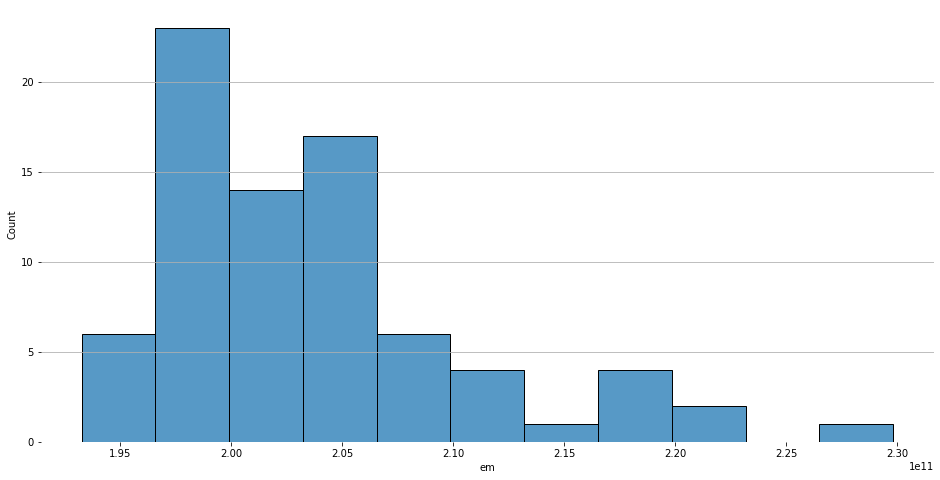

In [5]:
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (16,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
sns.histplot(df, x='em', ax=ax1)

In [6]:
df.head()

,Ua,x,I,u,v,e_u,e_v,em
0,5000,0.000,0.940,6.480186e-10,128.00,6.625240e-11,3.20,1.975252e+11
1,5000,0.010,0.815,5.024742e-10,98.00,5.183058e-11,2.80,1.950349e+11
2,5000,0.012,0.780,4.664957e-10,92.48,4.828008e-11,2.72,1.982441e+11
3,5000,0.014,0.750,4.381831e-10,87.12,4.550187e-11,2.64,1.988210e+11
4,5000,0.016,0.720,4.112098e-10,81.92,4.286073e-11,2.56,1.992170e+11


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ua      78 non-null     int64  
 1   x       78 non-null     float64
 2   I       78 non-null     float64
 3   u       78 non-null     float64
 4   v       78 non-null     float64
 5   e_u     78 non-null     float64
 6   e_v     78 non-null     float64
 7   em      78 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 5.0 KB


In [8]:
def modello(x, p, q):
    return x*p+q

p = 1/em
q = 0
popt, pcov = curve_fit(modello, df['v'], df['u'], p0 = (p, q), absolute_sigma=True, sigma = df['e_u'])
st_error=np.sqrt(np.diag(pcov))
print(f'rapporto e/m: {1/popt[0]:.4} ± {(st_error[0]/popt[0]**2):.4}')
print(f'errore relativo: {(st_error[0]/popt[0]**2)*popt[0]:.2}')
print(f'intercetta: {popt[1]:.4} ± {st_error[1]:.4}')
print(f'vero e/m: {em:.4}')
print(f'scarto relativo: {1/popt[0]/em:.4}')

rapporto e/m: 1.937e+11 ± 5.027e+09
errore relativo: 0.026
intercetta: -1.032e-11 ± 5.082e-12
vero e/m: 1.759e+11
scarto relativo: 1.101


In [9]:
def f(B, x):
    return B[0]*x + B[1]

linear = Model(f)
data = RealData(df['v'], df['u'], sx=df['e_v'], sy=df['u'])
odr=ODR(data, linear, beta0=[p, q])
output=odr.run()
print(f'rapporto e/m con odr: {1/output.beta[0]:.4} ± {(output.sd_beta[0]/output.beta[0]**2):.4}')
print(f'intercetta con odr: {output.beta[1]:.4} ± {output.sd_beta[1]:.4}')

rapporto e/m con odr: 1.937e+11 ± 9.457e+08
intercetta con odr: -1.031e-11 ± 8.868e-13


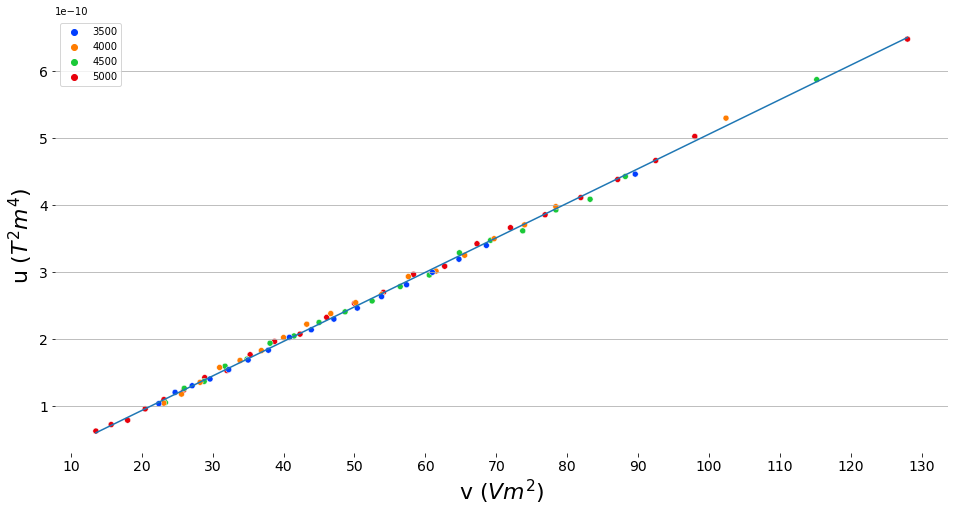

In [10]:
y=modello(df['v'], popt[0], popt[1])
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (16,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
sns.scatterplot(df, x='v', y='u', hue='Ua', ax=ax1, palette='bright')
sns.lineplot(x=df['v'], y=y, ax=ax1)
ax1.set_ylabel('u ($T^2m^4$)', fontsize = 22)
ax1.set_xlabel('v ($V m^2$)', fontsize = 22)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.xaxis.set_major_locator(plt.MultipleLocator(10))

0.5930016473055888 23
0.6281029386582754 18
0.7984299735888284 17
0.13502675904829003 16


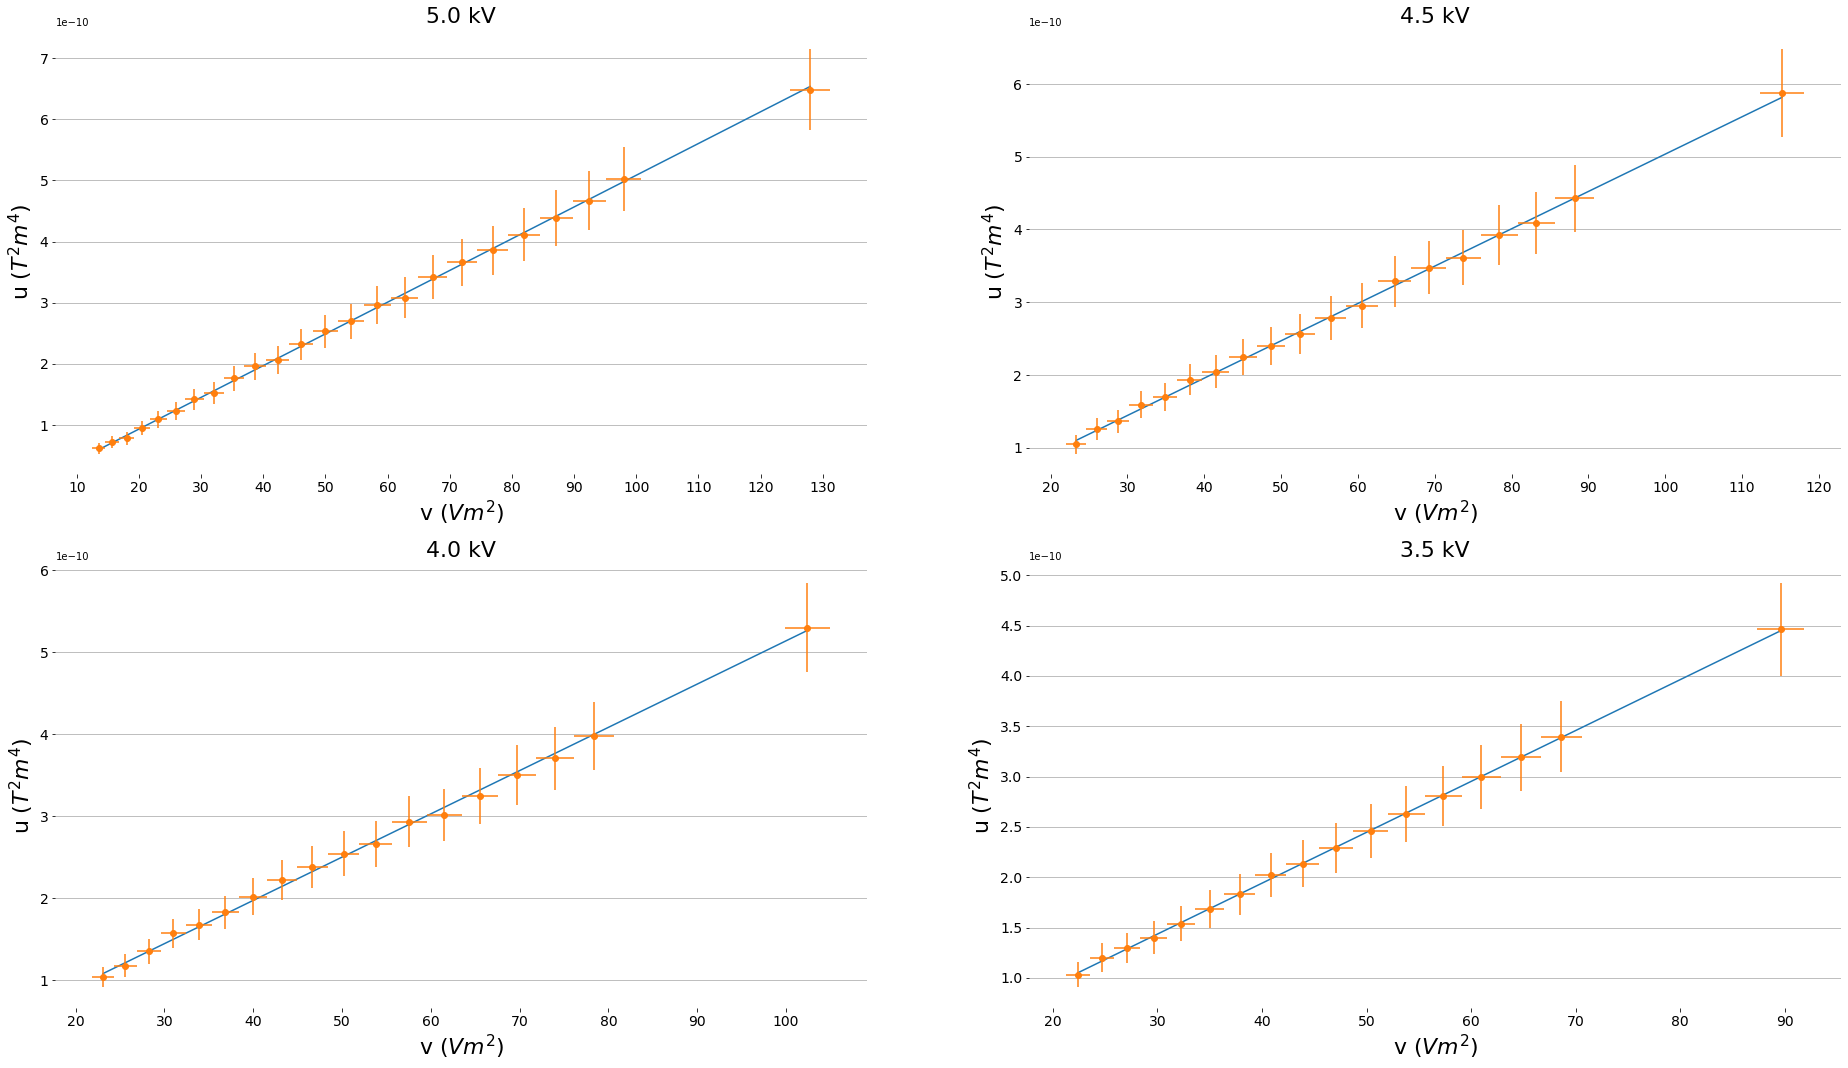

In [11]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (32,18))
ems = pd.DataFrame(columns=['e/m', 'σ e/m', 'intercetta', 'σ intercetta'], index=df['Ua'].unique())
for ua, ax in zip(df['Ua'].unique(), itertools.chain.from_iterable(axes)):
    poptx, pcovx = curve_fit(modello, df[df['Ua']==ua]['v'], df[df['Ua']==ua]['u'], p0 = (p, q), absolute_sigma=True, sigma = df[df['Ua']==ua]['e_u'])
    st_errorx=np.sqrt(np.diag(pcovx))
    ems.loc[ua]=[1/poptx[0]/1e11, (st_errorx[0]/poptx[0]**2)/1e11, poptx[1]*1e11, st_errorx[1]*1e11]
    y=modello(df[df['Ua']==ua]['v'], poptx[0], poptx[1])
    chi=np.sum((y-df[df['Ua']==ua]['u'])**2/df[df['Ua']==ua]['e_u']**2)
    print(chi, y.shape[0]-1)
    ax.grid(axis = 'y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('u ($T^2m^4$)', fontsize = 22)
    ax.set_xlabel('v ($V m^2$)', fontsize = 22)
    ax.set_title(f'{ua*1e-3} kV', fontsize = 22)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    sns.lineplot(x=df[df['Ua']==ua]['v'], y=y, ax=ax)
    ax.errorbar(df[df['Ua']==ua]['v'], df[df['Ua']==ua]['u'], df[df['Ua']==ua]['e_u'], df[df['Ua']==ua]['e_v'], fmt='o')
#plt.savefig('fig1.svg', bbox_inches = "tight")

In [12]:
ems.loc['complessivo']=[1/popt[0]/1e11, (st_error[0]/popt[0]**2)/1e11, popt[1]*1e11, st_error[1]*1e11]

In [13]:
em_scalato=em/1e11
ems['scarto e/m']=(ems['e/m']-em_scalato)/em_scalato
ems['z e/m']=np.abs((ems['e/m']-em_scalato)/ems['σ e/m'])
ems['p-value']=ems['z e/m'].apply(lambda x : norm.sf(x))
ems.head()

,e/m,σ e/m,intercetta,σ intercetta,scarto e/m,z e/m,p-value
5000,1.928254,0.07659,-1.01923,0.678931,0.096334,2.212228,0.013475
4500,1.948184,0.114804,-0.971661,1.31308,0.107665,1.649457,0.049527
4000,1.894723,0.119828,-1.390678,1.364899,0.077269,1.13415,0.128366
3500,1.977823,0.142802,-0.814834,1.401609,0.124517,1.533613,0.062562
complessivo,1.93722,0.050273,-1.031717,0.508169,0.101431,3.548644,0.000194
